In [74]:
import numpy as np
from numba import vectorize
import time

In [77]:

@vectorize(['float32(float32, float32)'], target='cuda')
def Add(a, b):
  return a + b

# Initialize arrays
N = 10000000
A = np.ones(N, dtype=np.float32)
B = np.ones(A.shape, dtype=A.dtype)
C = np.empty_like(A, dtype=A.dtype)

# Add arrays on GPU
t=time.time()
C = Add(A, B)
print(time.time()-t)

0.15755939483642578


In [78]:
@vectorize(['float32(float32, float32)'], target='cpu')
def Add(a, b):
  return a + b

# Initialize arrays
N = 10000000
A = np.ones(N, dtype=np.float32)
B = np.ones(A.shape, dtype=A.dtype)
C = np.empty_like(A, dtype=A.dtype)

# Add arrays on GPU
t=time.time()
C = Add(A, B)
print(time.time()-t)

0.014032363891601562


In [79]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

In [80]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

In [81]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Mandelbrot created in 4.790438 s


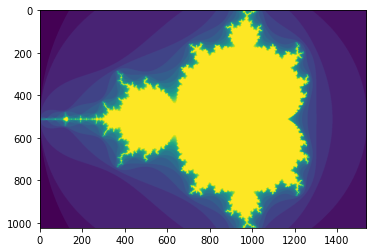

In [7]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

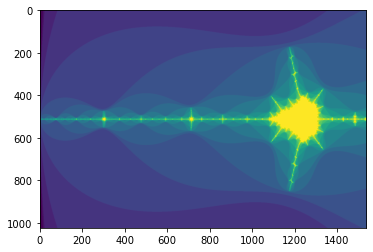

In [8]:
create_fractal(-2.0, -1.7, -0.1, 0.1, image, 20) 
imshow(image)
show()

### Numba

In [9]:
from numba import jit

@jit
def mandel2(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit
def create_fractal2(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel2(real, imag, iters)
      image[y, x] = color

Mandelbrot created in 0.519271 s


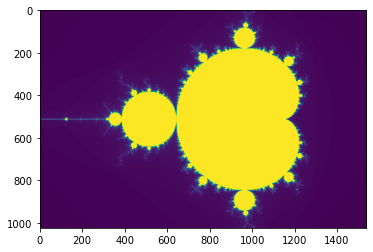

In [10]:

image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal2(-2.0, 1.0, -1.0, 1.0, image, 200) 
dt = timer() - start

print( "Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [11]:
from numba import cuda
from numba import *

mandel_gpu = cuda.jit(device=True)(mandel)

In [12]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

Mandelbrot created on GPU in 0.412801 s


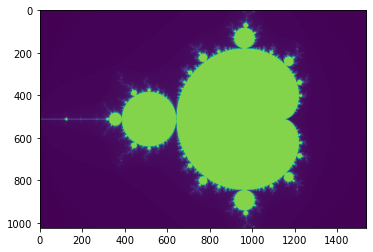

In [13]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 2000) 
d_image.to_host()
dt = timer() - start

print( "Mandelbrot created on GPU in %f s" % dt)

imshow(gimage)
show()

Mandelbrot created in 2.814557 s


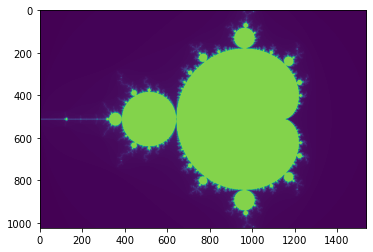

In [14]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal2(-2.0, 1.0, -1.0, 1.0, image, 2000) 
dt = timer() - start

print( "Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [15]:
test = np.zeros((12,2))
sample = np.zeros((10,))

In [16]:
blockdim = (32, 8)
griddim = (32,16)
for i, iters in enumerate([2,5,10,20,50,100,200,500,1000,2000,5000,10000]):
    
    #testing cuda_mandel
    
    
    for j in range(10):
        gimage = np.zeros((1024, 1536), dtype = np.uint8)
        start = timer()
        d_image = cuda.to_device(gimage)
        mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, iters) 
        d_image.to_host()
        sample[j] = timer() - start
    test[i,0] = np.median(sample)
    
    #testing numba_mandel
    for j in range(10):
        image = np.zeros((1024, 1536), dtype = np.uint8)
        start = timer()
        create_fractal2(-2.0, 1.0, -1.0, 1.0, image, iters) 
        sample[j] = timer() - start
    test[i,1] = np.median(sample)



In [17]:
test

array([[3.48425000e-03, 6.33495000e-03],
       [3.87535000e-03, 1.36680000e-02],
       [4.41360000e-03, 2.37673000e-02],
       [5.46255000e-03, 4.17230500e-02],
       [8.61535000e-03, 8.75551500e-02],
       [1.33827000e-02, 1.61201750e-01],
       [1.88368500e-02, 3.02993500e-01],
       [3.63689000e-02, 7.18506850e-01],
       [5.20789000e-02, 1.42385100e+00],
       [9.48589000e-02, 2.81965790e+00],
       [2.32181250e-01, 7.01163245e+00],
       [4.78021400e-01, 1.39378213e+01]])

In [18]:
from matplotlib import pyplot as plt

<Figure size 60x40 with 0 Axes>

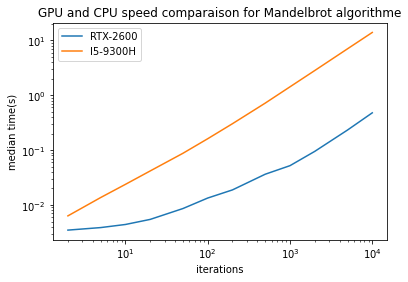

<Figure size 60x40 with 0 Axes>

In [19]:

plt.loglog([2,5,10,20,50,100,200,500,1000,2000,5000,10000],test)
plt.ylabel("median time(s)")
plt.xlabel("iterations")
plt.title("GPU and CPU speed comparaison for Mandelbrot algorithme")
plt.legend(["RTX-2600", "I5-9300H"])
plt.figure(dpi = 10)

In [68]:
test = np.zeros((10,2))
sample = np.zeros((10,))
blockdim = (32, 32)
griddim = (32,32)
for i in range(10):
    
    #testing cuda_mandel
    
    
    for j in range(10):
        gimage = np.zeros((100*(2**i), 1500), dtype = np.uint8)
        start = timer()
        d_image = cuda.to_device(gimage)
        mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
        d_image.to_host()
        sample[j] = timer() - start
    test[i,0] = np.median(sample)
    
    #testing numba_mandel
    
    for j in range(10):
        image = np.zeros((100*(2**i), 1500), dtype = np.uint8)
        start = timer()
        create_fractal2(-2.0, 1.0, -1.0, 1.0, image, 20) 
        sample[j] = timer() - start
    test[i,1] = np.median(sample)

<Figure size 60x40 with 0 Axes>

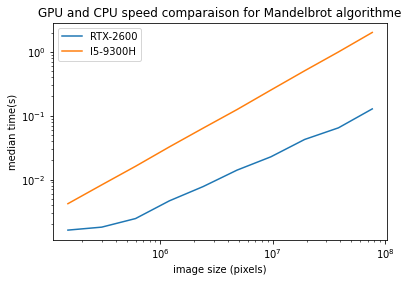

<Figure size 60x40 with 0 Axes>

In [69]:
plt.loglog([1500*100*(2**i)for i in range(10)],test)
plt.ylabel("median time(s)")
plt.xlabel("image size (pixels)")
plt.title("GPU and CPU speed comparaison for Mandelbrot algorithme")
plt.legend(["RTX-2600", "I5-9300H"])
plt.figure(dpi = 10)